# Inspect the convergence characteristics in DE

In [1]:
using Plots
using BenchmarkTools
using Random, Printf
using CSV, Tables
using Statistics
using DifferentialEvolution

In [2]:
# seed to reproduce our exact result
# comment it out and each run may generate a slightly different result
Random.seed!(123);  

In [3]:
# directory to store images: change it to your own one
const img_dir = "./img";

## Read data

In [4]:
const data_RT = CSV.File("data/RTFrance.csv") |> Tables.matrix;
const data_PW = CSV.File("data/Photowatt25.csv") |> Tables.matrix
@show size(data_RT)
@show size(data_PW);

size(data_RT) = (26, 2)
size(data_PW) = (25, 2)


## Set temperatures, search ranges, and import related functions

In [5]:
const T_RT = 33 + 273.15  # temperature in Kalvin of the RTC France case
const T_PW = 45 + 273.15;  # temperature in Kalvin of the Photowatt case

In [6]:
# see Table 1 in our paper
const bounds_RT_sdm = Float64[0 1; 0 1; 1 2; 0 0.5; 0 100];
const bounds_RT_ddm = Float64[0 1; 0 1; 0 1; 1 2; 1 2; 0 0.5; 0 100]; 
const bounds_PW_sdm = Float64[0 2; 0 50; 1 50; 0 2; 0 2000]; 
const bounds_PW_ddm = Float64[0 2; 0 0.01; 0 50; 1 50; 1 50; 0 2; 0 2000];

In [7]:
include("models.jl")  # import related functions

calculate_rmse

## Check one typical run for SDM on two datasets

In [8]:
const np = 50  # number of individuals
const F = 0.6
const Cr = 0.9
const G_sdm = 800 # number of generations
const G_ddm = 1600 # number of generations
;

### RT

In [9]:
# given a parameter vector θ, compute its SSE as the fitness in DE
evaluator(θ) = calculate_sse(data_RT, (V, I) -> model_sdm(V, I, θ..., T_RT));

In [10]:
# each run is new due to the involved randomness
de = StdDE(np, bounds_RT_sdm, StdOptions(F, Cr); senses=-1)  # minimization
records = evolve!(de, evaluator, G_sdm; stats=[], history=true) # max/min/avg/std

# get the minimum RMSE in each generation
rmse_sdm_RT = sqrt.(records[:, 2] ./ size(data_RT, 1))
@show size(rmse_sdm_RT);

size(rmse_sdm_RT) = (800,)


### PW

In [11]:
# given a parameter vector θ, compute its SSE as the fitness in DE
# note that the temperature of the two datasets are different
evaluator(θ) = calculate_sse(data_PW, (V, I) -> model_sdm(V, I, θ..., T_PW));

In [12]:
# each run is new due to the involved randomness
de = StdDE(np, bounds_PW_sdm, StdOptions(F, Cr); senses=-1)  # minimization
records = evolve!(de, evaluator, G_sdm; stats=[], history=true)

# get the minimum RMSE in each generation
rmse_sdm_PW = sqrt.(records[:, 2] ./ size(data_PW, 1))
@show size(rmse_sdm_PW);

size(rmse_sdm_PW) = (800,)


### Plot convergence curve

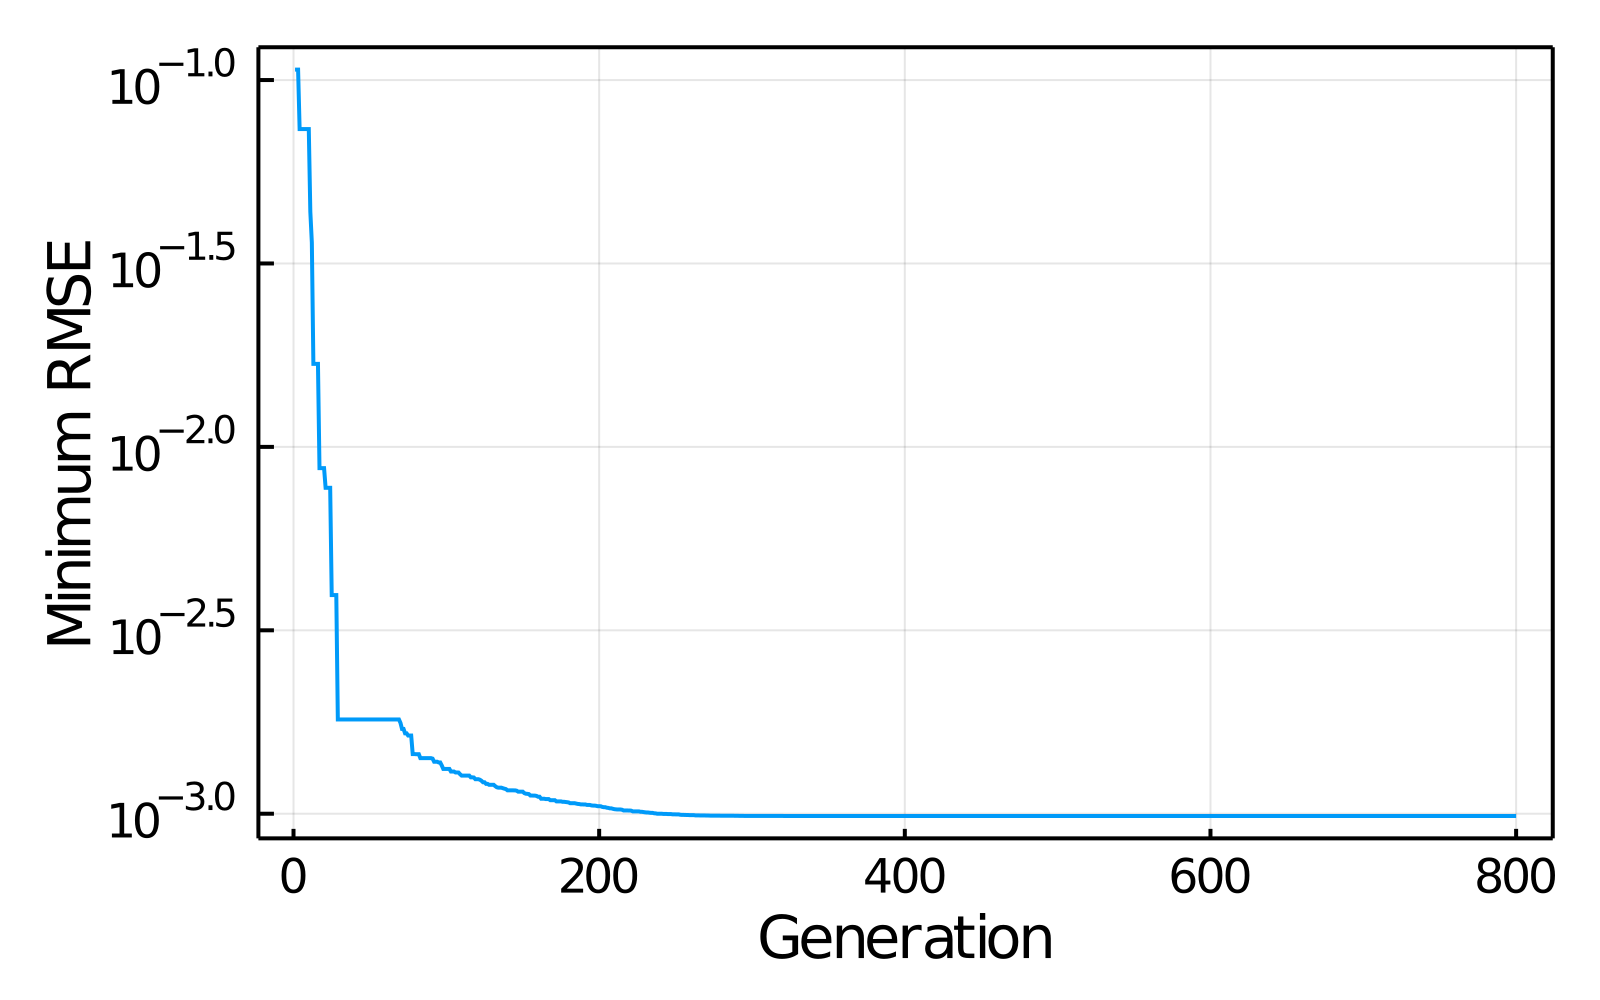

In [13]:
plot(size=(400, 250), labelfontsize=10, framestyle=:box)
plot!(1:G_sdm, rmse_sdm_RT; label=nothing, yaxis=:log, xlabel="Generation", ylabel="Minimum RMSE")

In [14]:
savefig(joinpath(img_dir, "converge_SDM_RT.pdf"))

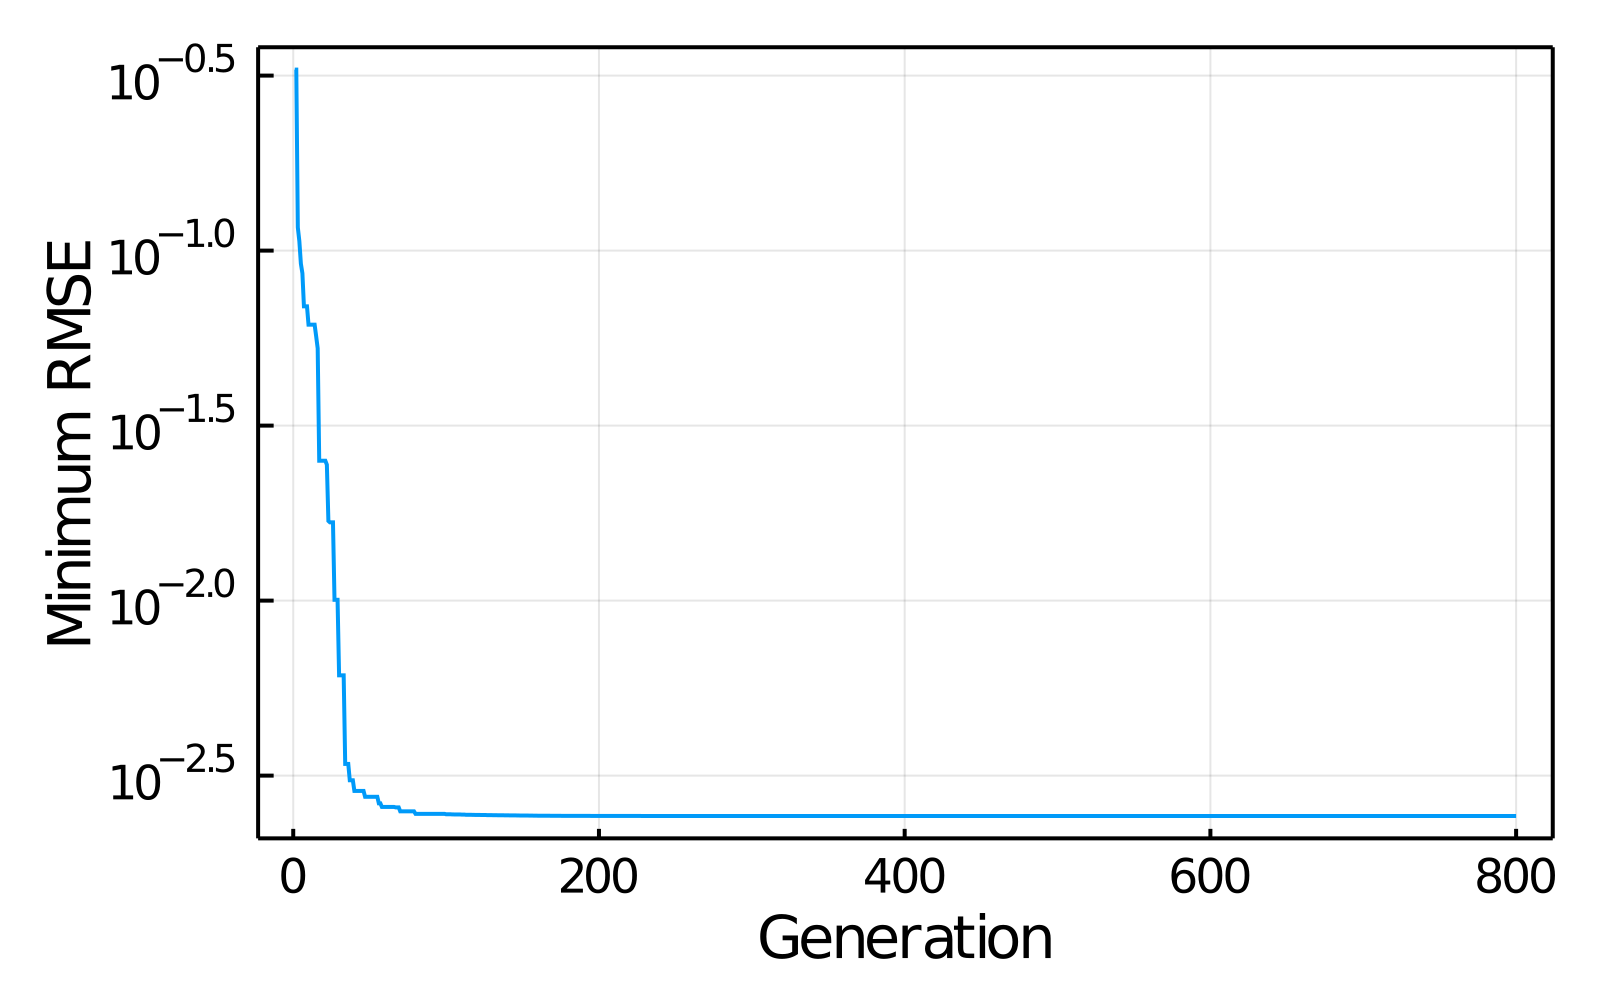

In [15]:
plot(size=(400, 250), labelfontsize=10, framestyle=:box)
plot!(1:G_sdm, rmse_sdm_PW; label=nothing, yaxis=:log, xlabel="Generation", ylabel="Minimum RMSE")

In [16]:
savefig(joinpath(img_dir, "converge_SDM_PW.pdf"))

## Check one typical run for DDM on two datasets

### RT

In [17]:
# given a parameter vector θ, compute its SSE as the fitness in DE
evaluator(θ) = calculate_sse(data_RT, (V, I) -> model_ddm(V, I, θ..., T_RT));

In [18]:
# each run is new due to the involved randomness
de = StdDE(np, bounds_RT_ddm, StdOptions(F, Cr); senses=-1)  # minimization
records = evolve!(de, evaluator, G_ddm; stats=[], history=true)
# get the minimum RMSE in each generation
rmse_ddm_RT= sqrt.(records[:, 2] ./ size(data_RT, 1));

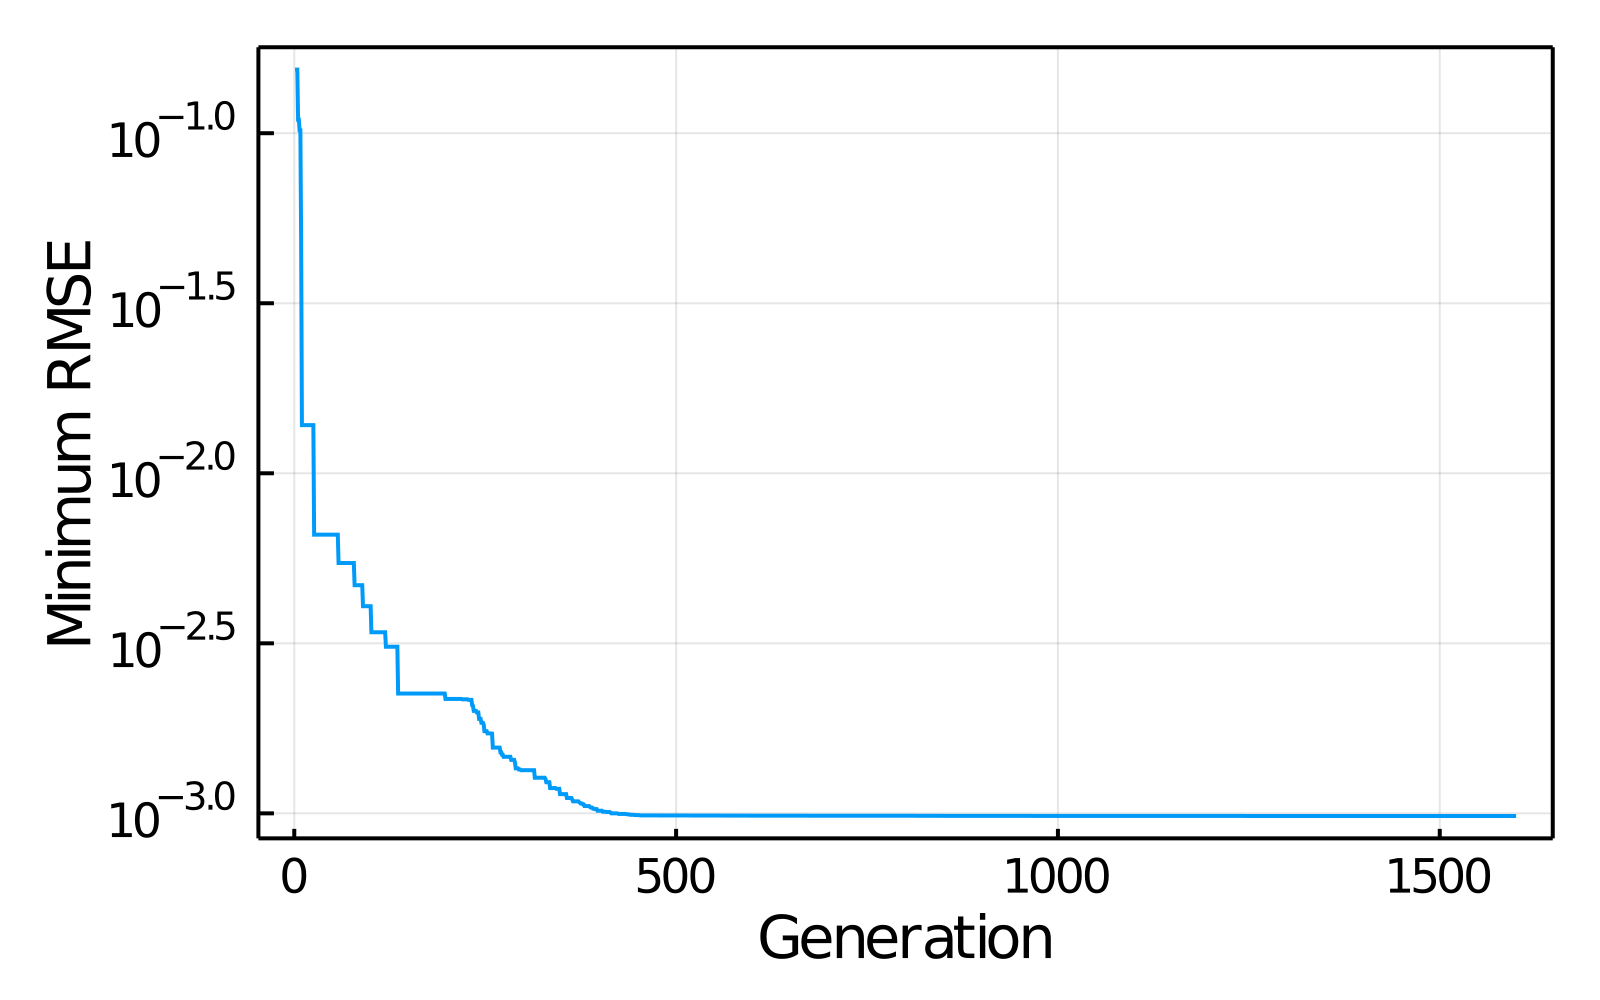

In [19]:
plot(size=(400, 250), labelfontsize=10, framestyle=:box, xlabel="Generation", ylabel="Minimum RMSE")
plot!(1:G_ddm, rmse_ddm_RT; label=nothing, yaxis=:log)

In [20]:
savefig(joinpath(img_dir, "converge_DDM_RT.pdf"))

### PW

In [21]:
# given a parameter vector θ, compute its SSE as the fitness in DE
evaluator(θ) = calculate_sse(data_PW, (V, I) -> model_ddm(V, I, θ..., T_PW));

In [22]:
# each run is new due to the involved randomness
de = StdDE(np, bounds_PW_ddm, StdOptions(F, Cr); senses=-1)  # minimization
records = evolve!(de, evaluator, G_ddm; stats=[], history=true)
# get the minimum RMSE in each generation
rmse_ddm_PW= sqrt.(records[:, 2] ./ size(data_PW, 1));

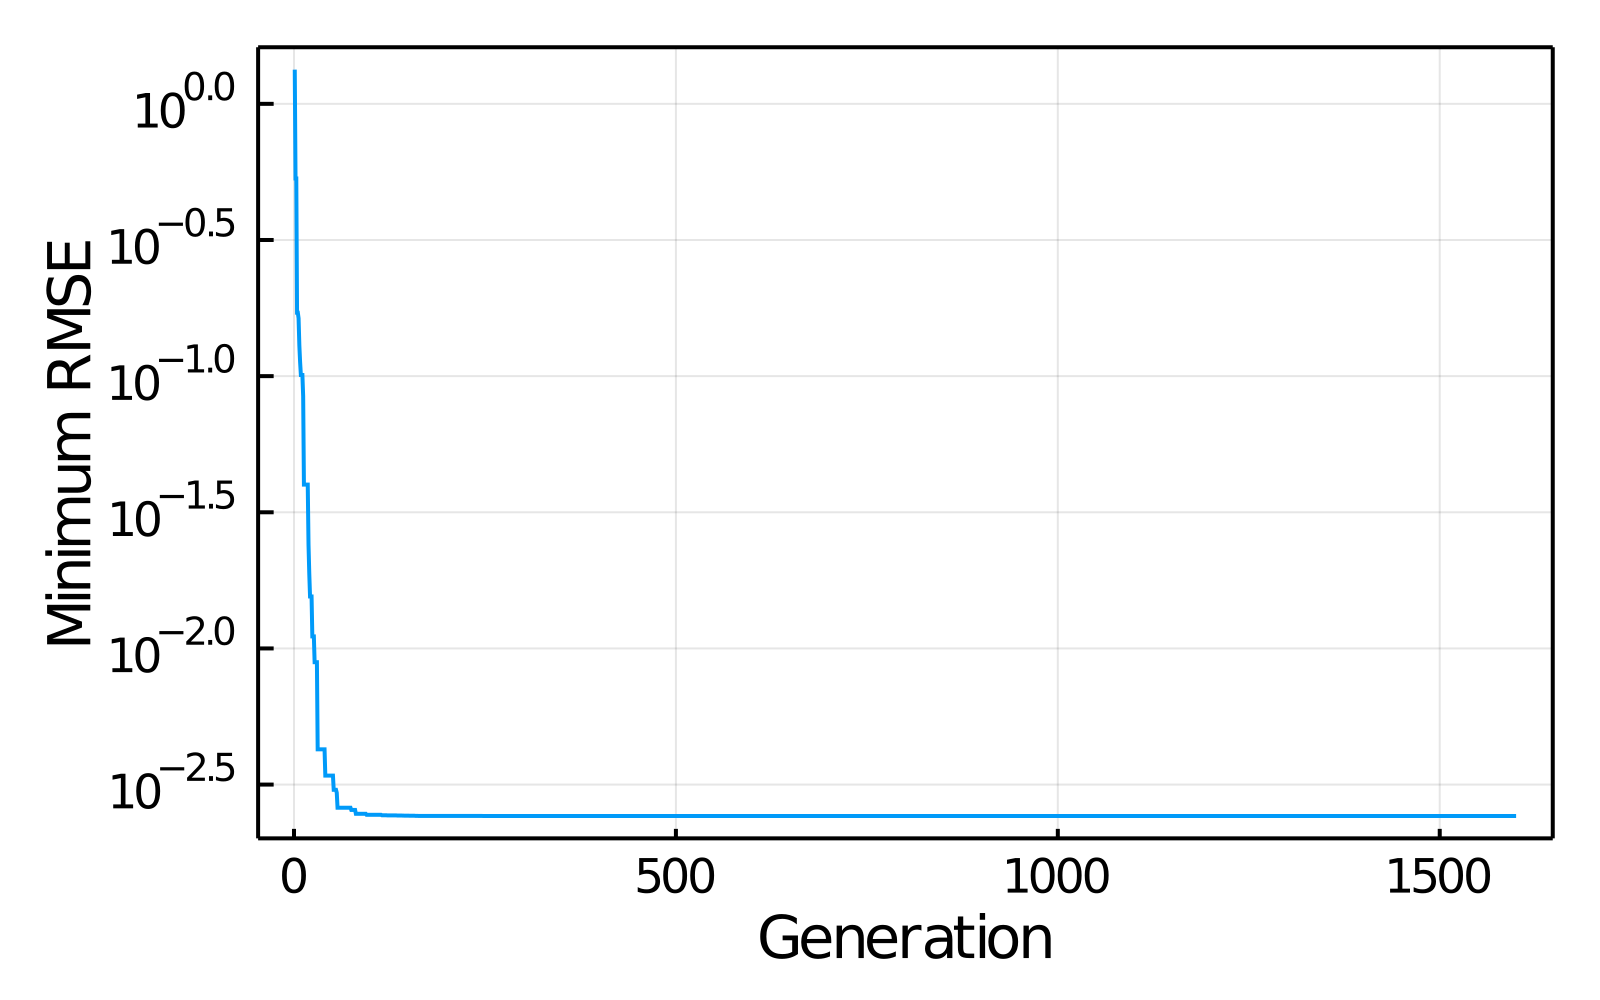

In [23]:
plot(size=(400, 250), labelfontsize=10, framestyle=:box, xlabel="Generation", ylabel="Minimum RMSE")
plot!(1:G_ddm, rmse_ddm_PW; label=nothing, yaxis=:log)

In [24]:
savefig(joinpath(img_dir, "converge_DDM_PW.pdf"))